In [16]:
"""
Created on Tuesday 9 Feb 2023
Author: ZAW
"""
#import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
from scipy import signal

In [17]:
# Read dataset for a , b, c value
# data path
path = os.getcwd()
dirname = os.path.dirname(path)
data_file = 'data/data.csv'
data_path = os.path.join(dirname,data_file)
data = pd.read_csv(data_path)

In [18]:
# View top 10 rows in dataframe
data.head(10)

,Label,Patient,A1_1Deg,A1_1Deg_err,B1_1Deg,B1_1Deg_err,C1_1Deg,C1_1Deg_err,1_Deg_ResSoS_1,1Deg_AdjR2_1,...,8_Deg_ResSoS_1,8Deg_AdjR2_1,A2_8Deg,A2_8Deg_err,B2_8Deg,B2_8Deg_err,C2_8Deg,C2_8Deg_err,8_Deg_ResSoS_2,8Deg_AdjR2_2
0,Not_Parkinson's,PD001,10.388190,0.006132,0.049329,0.000006,0.011989,0.000337,8928.709194,0.990598,...,6698.838281,0.951413,10.273124,0.044206,0.386347,0.000384,0.037356,0.002439,6809.455800,0.939095
1,Not_Parkinson's,PD002,10.429055,0.006929,0.049478,0.000007,0.002837,0.000379,11388.604704,0.988092,...,4769.901822,0.967360,11.482500,0.049154,0.395412,0.000380,-0.002486,0.002419,8383.481840,0.939586
2,Not_Parkinson's,PD003,10.097088,0.005091,0.049368,0.000006,0.005707,0.000287,6140.292312,0.993141,...,3488.747176,0.968709,10.084338,0.019838,0.394595,0.000174,-0.035466,0.001106,1349.962240,0.987259
3,Not_Parkinson's,PD004,10.482881,0.022179,0.049585,0.000023,0.016056,0.001212,117748.979710,0.879372,...,10972.045844,0.920137,11.493414,0.048867,0.401386,0.000377,-0.042463,0.002395,8242.136178,0.940370
4,Not_Parkinson's,PD005,10.181273,0.008833,0.049368,0.000010,0.001569,0.000494,18447.340517,0.979692,...,18268.960666,0.809586,10.370348,0.036121,0.395392,0.000308,-0.030769,0.001960,4485.300264,0.960035
5,Not_Parkinson's,PD006,10.302529,0.010450,0.049283,0.000011,0.019735,0.000580,25994.527943,0.972249,...,7175.782112,0.938474,10.356903,0.067627,0.410282,0.000584,-0.052723,0.003707,16046.923323,0.859535
6,Not_Parkinson's,PD007,9.934379,0.007838,0.049209,0.000009,0.003633,0.000449,14490.496516,0.983200,...,1465.027123,0.985896,9.801698,0.024067,0.397850,0.000217,-0.045138,0.001380,1986.965945,0.980134
7,Not_Parkinson's,PD008,9.861257,0.026999,0.049220,0.000030,0.051865,0.001576,176009.839073,0.798036,...,15508.422642,0.870504,8.591437,0.105215,0.415729,0.001098,-0.078941,0.006967,39005.324498,0.507026
8,Not_Parkinson's,PD009,10.221777,0.005149,0.049244,0.000006,0.002274,0.000287,6253.730577,0.993152,...,849.603210,0.992275,10.305625,0.022845,0.396998,0.000196,-0.056233,0.001244,1783.111545,0.983816
9,Not_Parkinson's,PD010,10.244784,0.017579,0.050004,0.000019,-0.015054,0.000981,73606.211066,0.920684,...,13818.787560,0.878166,10.997960,0.085181,0.406918,0.000690,-0.043189,0.004387,25335.919452,0.802179


In [19]:
# read SPEM data
data_001 = 'data/Parkinson_pursuit testing_Rec 40.xlsx'
data_path = os.path.join(dirname,data_001)
data_sp = pd.read_excel(data_path)

/Users/zaw/miniforge3/envs/ds/lib/python3.9/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [25]:
# for eye pixel calculating
def px_deg_eye(data,dominant_eye):
    time_eye = []
    pos_eye = []
    if dominant_eye == 'right':
        for y in data['GazePointRightX (ADCSpx)']:
            new_y = round((y - 960)/49.6,4) # horizontal center:960x540 pixel : 1 deg = 49.6 pixel
            pos_eye.append(new_y)
    elif dominant_eye == 'left':
        for y in data['GazePointLeftX (ADCSpx)']:
            new_y = round((y - 960)/49.6,4) # horizontal center:960x540 pixel : 1 deg = 49.6 pixel
            pos_eye.append(new_y)
    for x in range(1,len(pos_eye)+1):
        new_x = round((1/300)*x,4) # for tobii's eye tracker with 300 Hz sampling rate
        time_eye.append(new_x)
    return time_eye,pos_eye

In [26]:
# event starts and ends
option = ['URLStart','URLEnd'] # This is the values in the Studio event column where stimuli start and end events from dataset
sti = data_sp[data_sp['StudioEvent'].isin(option)].index # Caculating start and end of stimuli
data_eye_hc_first = data_sp[sti[0]+4000:sti[0]+28200] # Real recoding starting time
one_deg_time_eye , one_deg_pos_eye =  px_deg_eye(data_eye_hc_first,'right')

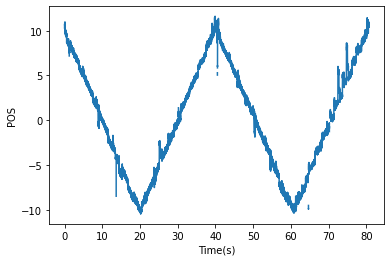

In [27]:
# Plot the data
plt.plot(one_deg_time_eye,one_deg_pos_eye)
plt.xlabel('Time(s)')
plt.ylabel('POS')
plt.show()

In [28]:
# # Filter
# import numpy as np
# import matplotlib.pyplot as plt

# # Define the period and number of samples per period
# period = 2*np.pi
# num_samples = 200

# # Create a sequence of time values for two periods
# t = np.linspace(0, 2*period, 2*num_samples)

# # Create a triangular wave with amplitude of 1
# tri_wave = np.abs((t % period) - (period/2)) - (period/4)

# # Plot the waveform
# plt.plot(t, tri_wave)
# plt.xlabel('Time')
# plt.ylabel('Amplitude')
# plt.show()

In [29]:
# Fitted values a, b, c
a = data.loc[1,'A1_1Deg',]
b = data.loc[1,'B1_1Deg',]
#c = data.loc[1,'C1_1Deg',]
period = 2*np.pi
num_samples = 200
filter_t = np.linspace(0, 2*period, 2*num_samples)
filter = signal.sawtooth(2 * np.pi * b * filter_t, width=a)

In [30]:
# Apply the filter to the noisy triangle wave
y = np.convolve(one_deg_time_eye, filter, mode='same')


In [31]:
# Compute filtered noise values as a DataFrame
noise_df = pd.DataFrame({'Time': one_deg_pos_eye, 'Noise': (one_deg_time_eye - y)})

In [32]:
# Identify segments
threshold = 0.05
noisy_segments = []
segment_start = None
for i in range(len(noise_df)):
    if abs(noise_df.loc[i, 'Noise']) > threshold:
        if segment_start is None:
            segment_start = i
    else:
        if segment_start is not None:
            segment_end = i
            noisy_segments.append((segment_start, segment_end))
            segment_start = None
if segment_start is not None:
    noisy_segments.append((segment_start, len(noise_df)))

In [182]:
noisy_segments 

[]

In [183]:
noise_df

,Time,Noise
0,10.3024,NaN
1,10.6250,NaN
2,10.4839,NaN
3,10.4435,NaN
4,10.6250,NaN
...,...,...
24195,10.3831,NaN
24196,10.7661,NaN
24197,10.4435,NaN
24198,10.9073,NaN


In [33]:
position = np.loadtxt('position.txt')
time = np.loadtxt('time.txt')

In [34]:
#Determine the start and end positions of the eye movement.
start_pos = position[0]
end_pos = position[-1]

In [35]:
#Calculate the distance traveled by the eye.
distance = np.abs(end_pos - start_pos)

In [36]:
#Calculate the duration of the eye movement.
duration = time[-1] - time[0]

In [37]:
#Calculate the gain of the eye movement.
gain = distance / duration

In [38]:
print('Gain:', gain)

Gain: 7.5920842858227395


In [41]:
# define sliding window parameters
window_size = 100  # number of data points in each window#
# On condtion
stride = 50  # number of data points to move the window for each iteration
# Need to put condition

In [42]:
# calculate standard deviation within each window
std_devs = []
for i in range(0, len(position) - window_size, stride):
    std_devs.append(np.std(position[i:i+window_size]))

In [1]:
# set a threshold to determine which segments are smooth
threshold = 1  # adjust as necessary
smooth_segments = []
for i in range(len(std_devs)):
    if std_devs[i] < threshold:
        start = i * stride
        end = start + window_size
        smooth_segments.append((start, end))

NameError: name 'std_devs' is not defined

In [45]:
# Define the positions and times arrays
positions = np.array([3.30000e-03, 6.70000e-03, 1.00000e-02, 9.00000e+01, 9.00033e+01, 9.00067e+01])
times = np.array([-0.121, -0.1008, -0.1815, 11.7339, 11.7742, 11.7339])

# Gain Calculation segment by segment

In [46]:
# define sliding window parameters
window_size = 100  # number of data points in each window
stride = window_size - threshold  # number of data points to move the window for each iteration


In [47]:
# calculate standard deviation within each window
std_devs = []
for i in range(0, len(position) - window_size, stride):
    std_devs.append(np.std(position[i:i+window_size]))

In [51]:
# set a threshold to determine which segments are smooth
threshold = 0.2  # adjust as necessary
smooth_segments = []
for i in range(len(std_devs)):
    if std_devs[i] < threshold:
        start = i * stride
        end = start + window_size

        # calculate derivative and sudden changes within each smooth segment
        dx = np.diff(position[start:end])
        sudden_changes = np.where(abs(dx) > threshold)[0]
        segment_starts = [start] + list(sudden_changes + start + 1)
        segment_ends = list(sudden_changes + start) + [end-1]
        segments = [(start, end) for start, end in zip(segment_starts, segment_ends)]
        smooth_segments.extend(segments)

# Need to modify
# now `smooth_segments` is a list of tuples containing the start and end indices of the smooth segments with sudden changes in position


In [54]:
len(dx)

99

In [55]:
dx

array([0.0034, 0.0033, 0.0033, 0.0034, 0.0033, 0.0033, 0.0034, 0.0033,
       0.0033, 0.0034, 0.0033, 0.0033, 0.0034, 0.0033, 0.0033, 0.0034,
       0.0033, 0.0033, 0.0034, 0.0033, 0.0033, 0.0034, 0.0033, 0.0033,
       0.0034, 0.0033, 0.0033, 0.0034, 0.0033, 0.0033, 0.0034, 0.0033,
       0.0033, 0.0034, 0.0033, 0.0033, 0.0034, 0.0033, 0.0033, 0.0034,
       0.0033, 0.0033, 0.0034, 0.0033, 0.0033, 0.0034, 0.0033, 0.0033,
       0.0034, 0.0033, 0.0033, 0.0034, 0.0033, 0.0033, 0.0034, 0.0033,
       0.0033, 0.0034, 0.0033, 0.0033, 0.0034, 0.0033, 0.0033, 0.0034,
       0.0033, 0.0033, 0.0034, 0.0033, 0.0033, 0.0034, 0.0033, 0.0033,
       0.0034, 0.0033, 0.0033, 0.0034, 0.0033, 0.0033, 0.0034, 0.0033,
       0.0033, 0.0034, 0.0033, 0.0033, 0.0034, 0.0033, 0.0033, 0.0034,
       0.0033, 0.0033, 0.0034, 0.0033, 0.0033, 0.0034, 0.0033, 0.0033,
       0.0034, 0.0033, 0.0033])

In [ ]:
dx

In [249]:
# Define the window size and threshold for detecting sudden changes
window_size = 10
threshold = 0.8

# Generate some sample eye movement data
y = np.random.rand(100) * 100
t = np.arange(100)

# Initialize the list to store the segments
segments = []

# Loop through the data with a sliding window
for i in range(window_size, len(y) - window_size):
    # Get the position and time data for the current window
    y_window = y[i-window_size:i+window_size]
    t_window = t[i-window_size:i+window_size]

    # Calculate the difference between the maximum and minimum positions in the window
    y_diff = np.max(y_window) - np.min(y_window)

    # Check if the difference exceeds the threshold
    if y_diff > threshold:
        # If so, record the segment
        y1 = np.min(y_window)
        y2 = np.max(y_window)
        t1 = np.min(t_window)
        t2 = np.max(t_window)
        segments.append((y1, y2, t1, t2))

# Print the segments that were found
print(segments)


[(0.6374966977722218, 96.17333092476049, 0, 19), (0.6374966977722218, 96.17333092476049, 1, 20), (0.6374966977722218, 94.16479331958205, 2, 21), (0.6374966977722218, 90.26907475084299, 3, 22), (0.6374966977722218, 90.26907475084299, 4, 23), (0.6374966977722218, 90.26907475084299, 5, 24), (0.6374966977722218, 90.26907475084299, 6, 25), (0.6374966977722218, 90.26907475084299, 7, 26), (0.6374966977722218, 90.26907475084299, 8, 27), (0.6374966977722218, 90.26907475084299, 9, 28), (0.6374966977722218, 90.26907475084299, 10, 29), (0.6374966977722218, 98.22653129407932, 11, 30), (0.6374966977722218, 98.22653129407932, 12, 31), (0.6374966977722218, 98.22653129407932, 13, 32), (15.178020019373983, 98.22653129407932, 14, 33), (15.178020019373983, 98.22653129407932, 15, 34), (15.178020019373983, 98.22653129407932, 16, 35), (15.178020019373983, 98.22653129407932, 17, 36), (15.178020019373983, 98.22653129407932, 18, 37), (15.178020019373983, 98.22653129407932, 19, 38), (15.178020019373983, 98.80583

In [13]:
# Set the threshold for sudden position changes
threshold = 0.2


# Initialize lists to store the segment start and end indices
segment_starts = []
segment_ends = []

# Iterate through the positions array, starting from the second position
i = 1
while i < len(positions):
    # Check if the current position is more than the threshold away from the previous position
    if abs(positions[i] - positions[i-1]) > threshold:
        # If it is, add the previous index as the start of a segment
        segment_starts.append(i-1)
        # Search for the end of the segment by iterating forward through the positions array
        j = i + 1
        while j < len(positions) and abs(positions[j] - positions[i-1]) > threshold:
            j += 1
        # Add the index before the last one as the end of the segment
        segment_ends.append(j-2)
        # Set the new position for i to the end of the current segment
        i = j-2
    else:
        # If the current position is not more than the threshold away from the previous position, increment i
        i += 1



In [14]:
# Print the segments with sudden position changes
if len(segment_starts) == 0:
    print("No segments with sudden position changes found")
else:
    print("Segments with sudden position changes:")
    # Initialize the start and end indices of the sliding window
    start = 0
    end = 1
    # Iterate through the segments
    for i, (start_pos, end_pos, start_time, end_time) in enumerate(zip(positions[segment_starts], positions[segment_ends], times[segment_starts], times[segment_ends])):
        #print(f"Segment {i+1}: Position ({start_pos}, {end_pos}), Time ({start_time}, {end_time})")
        # Set the window size to be dependent on the start of the sudden position change
        window_size = int(round(0.1 * (start_pos - positions[start]))) # window size is 10% of the distance between the current segment start and the previous segment start
        # Initialize lists to store the gains and durations for the current segment
        gains = []
        durations = []
        # Iterate through the positions and times arrays for the current segment
        for j in range(segment_starts[i], segment_ends[i]):
            # Calculate the change in position and time between the current point and the next point in the window
            delta_y = positions[j+1] - positions[j]
            delta_x = times[j+1] - times[j]
            # Calculate the speed between the current point and the next point in the window
            speed = delta_y / delta_x
            # Calculate the gain and duration for the window
            window_gain = speed / (end_pos - start_pos)
            window_duration = times[j+1] - start_time
            # Add the gain and duration to the lists for the current segment
            gains.append(window_gain)
        total_gain = np.sum(gains)
        print(f"Total gain : {total_gain}")

Segments with sudden position changes:
Total gain : 0.0848318377197182


In [2]:
gain


NameError: name 'gain' is not defined